<a href="https://colab.research.google.com/github/lukasoares/Twitter_Sentiment_Analysys_With_Roberta/blob/main/TwitterSentimentAnalysysWithRoberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Instalando e importando as bibliotecas

In [2]:
!pip install tweepy==4.5.0 --upgrade
!pip install transformers
import tweepy as tw
import pandas as pd
from nltk.tokenize import word_tokenize
import nltk 
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from string import punctuation
from wordcloud import WordCloud, ImageColorGenerator
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageOps
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from scipy.special import softmax
import plotly.express as px

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 KB 5.9 MB/s eta 0:00:00
  Attempting uninstall: tweepy
    Found existing installation: tweepy 4.13.0
    Uninstalling tweepy-4.13.0:
      Successfully uninstalled tweepy-4.13.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 80.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 15.7 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Fazendo a autenticação pela API do Twitter
Como são dados sensíveis de acesso a uma conta, retirei os dados de autenticação de um documento utilizando "with open".

In [ ]:
with open('twitter-chaves.txt', 'r') as tchaves:
  consumer_key = tchaves.readline().strip('\n')
  consumer_secret_key = tchaves.readline().strip('\n')
  bearer_token = tchaves.readline().strip('\n')
  access_token = tchaves.readline().strip('\n')
  access_token_secret = tchaves.readline().strip('\n')

In [ ]:
client = tw.Client(bearer_token= bearer_token, consumer_key = consumer_key, consumer_secret= consumer_secret_key, access_token= access_token, access_token_secret = access_token_secret,wait_on_rate_limit=True)

##Consulta e extração dos tweets

A consulta utilizada foi "the last of us", retirando os retweets com o parâmetro "-is:retweet" e buscando apenas no idioma inglês com o parâmetro "lang:en".

Por padrão, as informações dos tweets coletados contêm o ID da postagem e o campo de texto. Para adquirir outras informações, foi necessário especificá-las por meio do uso dos parâmetros 'fields' ou pelo argumento 'expansions'. Neste exemplo, foram adicionados a data de criação da postagem ('tweet_fields = ['created_at']), a localização do usuário ('user_fields = ['location']), o ID do usuário ('author_id') e um resultado de 100 tweets por pesquisa ('max_results = 100'). A coleta de dados pode ser personalizada de várias maneiras, e para obter mais informações sobre os 'fields', acesse o seguinte link: https://developer.twitter.com/en/docs/twitter-api/fields

In [ ]:
nome = []
localizacao =[]
textos = []
creat_at = []
user_id = []

In [ ]:
response = client.search_recent_tweets(query="the last of us -is:retweet lang:en", tweet_fields=['id', 'created_at'], expansions=['author_id', 'geo.place_id'],
                                       user_fields=['location', 'username'], max_results=100, start_time = '2023-03-15T00:00:01Z', end_time = '2023-03-21T00:00:00Z')

In [ ]:
users = {u['id'] : u for u in response.includes['users']}

In [ ]:
for tweet in response.data:
# Com o dicionário "users" com as informações dos usuários criado, podemos mapear essas informações utilizando
# o id do usuário que também esta presente na variável que criamos no laço 'tweet'.
  if users[tweet.author_id]:
    user = users[tweet.author_id]
    nome.append(user.username)
    localizacao.append(user.location)
  user_id.append(tweet.author_id)
  textos.append(tweet.text)
  creat_at.append(tweet.created_at)

Para que seja possível colhetar mais de 100 tweets, foi utilizado o método "meta" que extrai metadados (dados sobre os dados) da resposta de uma solicitação à API do Twitter e armazena esses metadados em uma variável chamada 'metadata'.

A próxima linha de código, 'next_token = metadata.get('next_token')', extrai o valor do token de paginação 'next_token' do dicionário 'metadata' e armazena o valor do token em uma variável chamada 'next_token'. O token de paginação é um valor exclusivo que é gerado pela API do Twitter e permite que os usuários paginem pelos resultados de suas solicitações de API.


In [ ]:
metadata = response.meta

next_token = metadata.get('next_token')

Foi construído um loop 'while' que funciona enquanto a variável 'next_token' tiver um valor. Isso significa que o loop irá executar enquanto houver páginas de comentários a serem extraídas. Além disso, o loop será interrompido se o número de solicitações feitas à API do Twitter alcançar 500 ou se o número de páginas extraídas atingir 500.

In [ ]:
max_requests = 500  # Definir o limite de solicitações
num_requests = 0  # Inicializar o número de solicitações realizadas

while next_token is not None and num_requests < max_requests:
  response = client.search_recent_tweets(query="the last of us -is:retweet lang:en", tweet_fields=['id', 'created_at'], expansions=['author_id', 'geo.place_id'],
                                       user_fields=['location', 'username'], max_results=100,
                                       next_token=next_token)
  users = {
  u['id']: u for u in response.includes['users']}
  
  for tweet in response.data:
    if users[tweet.author_id]:
      user = users[tweet.author_id]
      nome.append(user.username)
      localizacao.append(user.location)
    user_id.append(tweet.author_id)
    textos.append(tweet.text)
    creat_at.append(tweet.created_at)
    metadata = response.meta

  next_token = metadata.get('next_token')
  num_requests += 1  # Aumentar o número de solicitações realizadas
  print(next_token)

E foi criado um DataFrame com as listas com os dados adquiridos

In [ ]:
df_novo=pd.DataFrame({'Textos' : textos, 'Usuário' : nome, 'Criado em': creat_at, "Localização" : localizacao, 'user_id': user_id})
df_novo.drop_duplicates(inplace= True)
df_novo

,Textos,Usuário,Criado em,Localização,user_id
0,I really don’t understand the microcosm of Tex...,HTXSportsSpeak,2023-03-20 23:59:45+00:00,None,1579000206036811783
1,The Long Dark + The Last of Us…is basically ju...,CallMeFebel,2023-03-20 23:59:22+00:00,Ohio,954792626514989058
2,@Envious i had someone come out last week and ...,ki__en,2023-03-20 23:59:20+00:00,aniღ,752325528
3,Was invited to discuss The Last of Us S1 on Th...,drewXdeficit,2023-03-20 23:59:10+00:00,Saint Louis,87861464
4,The last autograph I got at the Spectacular wa...,crawlyscubs,2023-03-20 23:59:08+00:00,1060 West Addison,277814587
...,...,...,...,...,...
48817,New story on NPR: 'The Last of Us' game actors...,danchamorro,2023-03-16 09:47:46+00:00,Charlotte,402866035
48818,@MerleDandridge @clmazin @TheLastofUsHBO You w...,rshah2611,2023-03-16 09:47:25+00:00,"Mumbai, India",1730193692
48819,@kevinboor54 @BlackstonesMDL @HucknallTownFc @...,sean48w,2023-03-16 09:47:23+00:00,None,714479624
48820,"@MichaelM238 The Last of Us Remastered is, I t...",WillFletchUK,2023-03-16 09:47:05+00:00,Derbyshire & London,23935768


Salvando os dados:

In [ ]:
df_novo.to_csv('the_last_of_usEn.csv')

##Pré-processamento dos tweets para Word Cloud

In [4]:
df_novo = pd.read_csv('/content/drive/MyDrive/base_de_dados/the_last_of_usEn.csv')

Primeiramente foi feita a tokenização dos comentários, separando por " ".

In [5]:
word_tokens=[]
for comentario in df_novo.Textos.str.lower():   
    word_tokens = word_tokens + word_tokenize(comentario) 
  


Foi utilizado o módulo 'punctuation' em conjunto com as stopwords do pacote 'nltk'. Estes são os termos e caracteres que serão removidos dos textos.

In [6]:
pontuacao = [ponto for ponto in punctuation]

In [7]:
stop_words = set(stopwords.words('english')) 
stop_words_with_pont_last = stop_words | set(punctuation) | set(["last"])

E agora é possível realizar a filtragem das palavras:


In [8]:
filtered_word_comentaries = [w for w in word_tokens if not w in stop_words_with_pont_last] 

Para que a nuvem de palavras seja mais informativa e contenha dados relevantes para uma melhor compreensão dos sentimentos dos usuários, foi realizada uma filtragem de palavras usando adjetivos.

In [9]:
adjs = [word for (word, pos) in nltk.pos_tag(filtered_word_comentaries) if (pos[:2] == 'JJ' and word.isalpha() and not (word.startswith('http')))]
print (adjs[:10])

['hard', 'single', 'actual', 'dark', 'envious', 'u', 'wrong', 'good', 'central', 'spectacular']


In [10]:
todas_palavras = ' '.join([texto for texto in adjs])

In [11]:
mask = np.array(Image.open('/content/drive/MyDrive/pngegg (1).png'))
image_colors = ImageColorGenerator(mask)
mask = np.invert(mask)



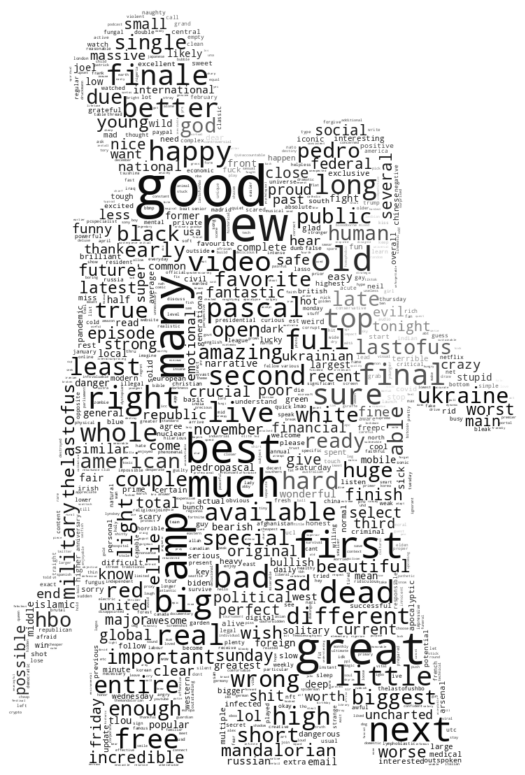

In [12]:
nuvem_palavras = WordCloud(background_color= "white",
                          max_font_size=80, max_words=1000, min_word_length=3,
                          collocations=False, mask=mask,
                        ).generate(todas_palavras)
plt.figure(figsize=(20,14))

plt.imshow(nuvem_palavras.recolor(color_func=image_colors,random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

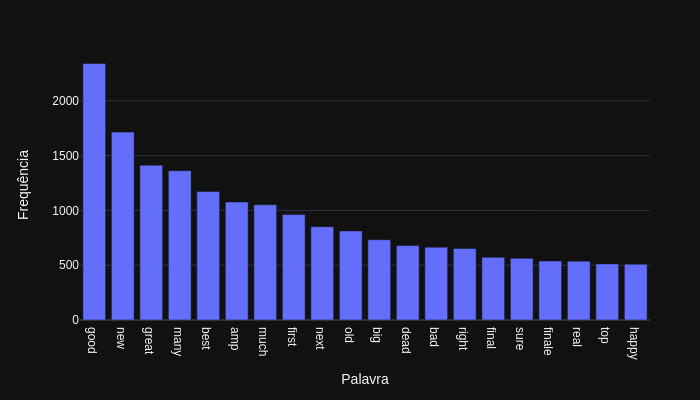

In [13]:
frequencia = nltk.FreqDist(adjs)
df_frequencia = pd.DataFrame({"Palavra": list(frequencia.keys()), "Frequência": list(frequencia.values())}).sort_values(by = 'Frequência', ascending = False)
fig = px.bar(data_frame = df_frequencia[:20], x= 'Palavra', y = 'Frequência')
fig.update_layout(height=400, width=700, template="plotly_dark", showlegend=False, margin=dict(t=50, r =50))
fig.show('png')

##Pré-processamento dos dados para serem utilizados no modelo "Roberta"


Para aplicar o modelo, primeiro removemos as pontuações e as stopwords, como foi feito anteriormente. No entanto, desta vez, vamos juntar essas palavras novamente em cada comentário, criando uma única string e adicionando essa nova string em uma nova coluna do DataFrame.

In [32]:
stop_words_2 = stop_words | set(punctuation)

In [33]:
frase_processada = []
for comentario in df_novo.Textos.str.lower():
  nova_frase = []
  palavras_texto = word_tokenize(comentario)
  for palavra in palavras_texto:
    if palavra not in stop_words_2:
      nova_frase.append(palavra)
  frase_processada.append(' '.join(nova_frase))  

In [34]:
df_novo['Tratamento'] = frase_processada

In [24]:
df_novo.head()

,Unnamed: 0,Textos,Usuário,Criado em,Localização,user_id,Tratamento
0,0,I really don’t understand the microcosm of Tex...,HTXSportsSpeak,2023-03-20 23:59:45+00:00,NaN,1579000206036811783,really ’ understand microcosm texans twitter r...
1,1,The Long Dark + The Last of Us…is basically ju...,CallMeFebel,2023-03-20 23:59:22+00:00,Ohio,954792626514989058,long dark last us…is basically start winter se...
2,2,@Envious i had someone come out last week and ...,ki__en,2023-03-20 23:59:20+00:00,aniღ,752325528,envious someone come last week told found w 5 ...
3,3,Was invited to discuss The Last of Us S1 on Th...,drewXdeficit,2023-03-20 23:59:10+00:00,Saint Louis,87861464,invited discuss last us s1 keeg tonight https ...
4,4,The last autograph I got at the Spectacular wa...,crawlyscubs,2023-03-20 23:59:08+00:00,1060 West Addison,277814587,last autograph got spectacular hall famer pat ...


Baixando o modelo "Roberta" e seu Tokenizer

In [27]:
roberta = "cardiffnlp/twitter-roberta-base-sentiment"

model = AutoModelForSequenceClassification.from_pretrained(roberta)
tokenizer = AutoTokenizer.from_pretrained(roberta)

labels = ['Negative', 'Neutral', 'Positive']

##Tokenização, vetorização e aplicação dos dados no modelo "Roberta"
Foi criada uma lista para receber os valores das probabilidades geradas por Roberta que foram padronizadas pela "softmax". Esses "scores" foram transformados em um Data Frame, utilizando os sentimentos como nome das colunas.

In [30]:
notas = []
for comentarie in df_novo['Tratamento']:
  encoded_tweet = tokenizer(comentarie, return_tensors='pt')
  output = model(**encoded_tweet)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  notas.append(scores)

In [39]:
df_scores = pd.DataFrame(notas, columns = ['Negative', 'Neutral', 'Positive'])
df_scores.head()

Salvando o novo DataFrame

In [40]:
df_scores.to_csv('Scores_tlou.csv')

In [15]:
df_scores = pd.read_csv('/content/drive/MyDrive/base_de_dados/Scores_tlou.csv').drop('Unnamed: 0', axis = 1)
df_scores.head()

,Negative,Neutral,Positive
0,0.676216,0.304348,0.019436
1,0.049718,0.891341,0.058941
2,0.355816,0.497134,0.147049
3,0.014120,0.929169,0.056712
4,0.001837,0.025893,0.972271


Foi utilizado o método "idxmax" que retorna o nome da coluna que contém o maior valor. Ou seja, ele retorna o sentimento que tem a maior probabilidade de acordo com a previsão do modelo.

In [16]:
df_scores['classificacao'] = df_scores.idxmax(axis=1)

In [17]:
df_scores.head()

,Negative,Neutral,Positive,classificacao
0,0.676216,0.304348,0.019436,Negative
1,0.049718,0.891341,0.058941,Neutral
2,0.355816,0.497134,0.147049,Neutral
3,0.014120,0.929169,0.056712,Neutral
4,0.001837,0.025893,0.972271,Positive


Juntando os dois DataFrames criados

In [18]:
final_df = pd.concat([df_novo, df_scores], axis = 1).drop('Unnamed: 0', axis = 1)
final_df.head()

,Textos,Usuário,Criado em,Localização,user_id,Negative,Neutral,Positive,classificacao
0,I really don’t understand the microcosm of Tex...,HTXSportsSpeak,2023-03-20 23:59:45+00:00,NaN,1579000206036811783,0.676216,0.304348,0.019436,Negative
1,The Long Dark + The Last of Us…is basically ju...,CallMeFebel,2023-03-20 23:59:22+00:00,Ohio,954792626514989058,0.049718,0.891341,0.058941,Neutral
2,@Envious i had someone come out last week and ...,ki__en,2023-03-20 23:59:20+00:00,aniღ,752325528,0.355816,0.497134,0.147049,Neutral
3,Was invited to discuss The Last of Us S1 on Th...,drewXdeficit,2023-03-20 23:59:10+00:00,Saint Louis,87861464,0.014120,0.929169,0.056712,Neutral
4,The last autograph I got at the Spectacular wa...,crawlyscubs,2023-03-20 23:59:08+00:00,1060 West Addison,277814587,0.001837,0.025893,0.972271,Positive


In [19]:
classification = final_df.classificacao.value_counts(normalize = True)*100
classification

Neutral     60.077027
Positive    20.780924
Negative    19.142049
Name: classificacao, dtype: float64

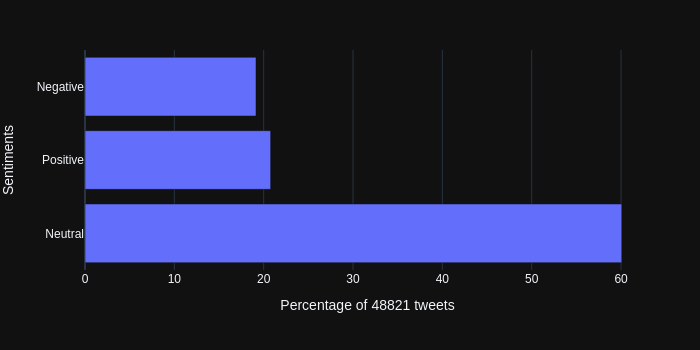

In [20]:
fig = px.bar(classification, orientation = 'h').update_xaxes(title = "Percentage of 48821 tweets").update_yaxes(title = "Sentiments")
fig.update_layout(height=350, width=700, template="plotly_dark", showlegend=False, margin=dict(t=50, r =50))
fig.show('png')


Após analisar o gráfico, podemos concluir que as opiniões relativas a essa amostra estão bastante divididas. As opiniões positivas representam 20,78% dos comentários e as negativas representam 19%. As opiniões neutras correspondem a 60% da amostra.